In [19]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import percentileofscore

from battleship.scoring import compute_score, compute_score_parallel
from battleship.prompting import HUMAN_DATASET_PATH
from battleship.board import Board

# Configure matplotlib for retina display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configure seaborn
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.25)

In [20]:
RESULTS_DIR = "results_official"

# Load the data

In [21]:
HUMAN_DATA_PATH = os.path.join(RESULTS_DIR, "human_question_dataset_scored.csv")

# Compute scores if they don't exist
if not os.path.exists(HUMAN_DATA_PATH):
    df_human = pd.read_csv(HUMAN_DATASET_PATH)
    df_human["score"] = [
        compute_score(program=program, board=Board.from_trial_id(trial_id))
        for program, trial_id in zip(df_human["code"], df_human["trial"])
    ]
    df_human["model"] = "Human"
    df_human.to_csv(HUMAN_DATA_PATH, index=False)
else:
    df_human = pd.read_csv(HUMAN_DATA_PATH)

df_human = df_human.rename(columns={"trial": "trial_id", "code": "program"})
df_human

trial_id                                           question  \
0           1                          Are all ships horizontal?   
1           1                     Are any of the ships touching?   
2           1                        Are any ships 2 tiles long?   
3           1  At what location is the top left part of the r...   
4           1  At what location is the top left part of the r...   
..        ...                                                ...   
600        18                      Is there a purple tile at 1A?   
601        18                      Is there a purple tile at 2C?   
602        18  Is there any part of the purple ship in column B?   
603        18                               What color is at 1A?   
604        18                               What color is at 3A?   

                                               program     score  model  
0    (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937  Human  
1    (or (or (touch Blue Purple) (touch Purple Red)...  0.988805  Human  
2    (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446  Human  
3                         (topleft (coloredTiles Red))  4.669496  Human  
4                         (topleft (coloredTiles Red))  4.669496  Human  
..                                                 ...       ...    ...  
600                             (== (color 1A) Purple)  0.954434  Human  
601                             (== (color 2C) Purple)  0.811278  Human  
602  (any (map (lambda y0 (== (colL y0) 2)) (colore...  0.954434  Human  
603                                         (color 1A)  0.954434  Human  
604                                         (color 3A)  1.000000  Human  

[605 rows x 5 columns]

In [22]:
df_codellama_7b = pd.read_csv(os.path.join(RESULTS_DIR, "CodeLlama-7b-hf-2024-01-23-04-52-40", "results_corrected.csv"))
df_codellama_7b["model"] = "CodeLlama-7b"
# rename completion -> question and translation -> program
df_codellama_7b = df_codellama_7b.rename(columns={"completion": "question", "translation": "program"})
df_codellama_7b

trial_id                            question  \
0            1  How many tiles is the purple ship?   
1            1                What color is at 2F?   
2            1         Is the red ship horizontal?   
3            1        Is there a water tile at 3D?   
4            1              Is there a ship at 2F?   
...        ...                                 ...   
1795        18                What color is at 1B?   
1796        18    Is the purple ship 4 tiles long?   
1797        18                What color is at 5B?   
1798        18    How many tiles is the blue ship?   
1799        18              Is there a ship at 3F?   

                                                program     score   type  \
0                                         (size Purple)  1.360775  final   
1                                            (color 2F)  1.418245  final   
2                                   (== (orient Red) H)  0.993542  final   
3                                 (== (color 3D) Water) -0.000000  final   
4                                            (color 2F)  1.418245  final   
...                                                 ...       ...    ...   
1795                                           (at 1 B)       NaN  final   
1796                               (== (size Purple) 4)  0.811278  final   
1797                                            (at 5B)       NaN  final   
1798                                        (size Blue) -0.000000  final   
1799  (any (map (lambda x0 (== (coord x0) 3F)) (set ...       NaN  final   

      prompt_id         model  
0             0  CodeLlama-7b  
1             0  CodeLlama-7b  
2             0  CodeLlama-7b  
3             0  CodeLlama-7b  
4             0  CodeLlama-7b  
...         ...           ...  
1795         19  CodeLlama-7b  
1796         19  CodeLlama-7b  
1797         19  CodeLlama-7b  
1798         19  CodeLlama-7b  
1799         19  CodeLlama-7b  

[1800 rows x 7 columns]

In [23]:
df_gpt4_textual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-25-15-02-02-textual", "results.csv"))
df_gpt4_textual["model"] = "GPT-4 (textual, few-shot)"
df_gpt4_textual["board_format"] = "textual"
df_gpt4_textual["few_shot"] = True

df_gpt4_textual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-00-48-40-textual-zero-shot", "results.csv"))
df_gpt4_textual_zero_shot["model"] = "GPT-4 (textual, zero-shot)"
df_gpt4_textual_zero_shot["board_format"] = "textual"
df_gpt4_textual_zero_shot["few_shot"] = False

df_gpt4_grid = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-01-27-01-grid", "results.csv"))
df_gpt4_grid["model"] = "GPT-4 (grid, few-shot)"
df_gpt4_grid["board_format"] = "grid"
df_gpt4_grid["few_shot"] = True

df_gpt4_grid_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-02-02-26-grid-zero-shot", "results.csv"))
df_gpt4_grid_zero_shot["model"] = "GPT-4 (grid, zero-shot)"
df_gpt4_grid_zero_shot["board_format"] = "grid"
df_gpt4_grid_zero_shot["few_shot"] = False

# df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-20-08-00-visual", "results.csv"))
df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-27-23-44-54-visual", "results.csv"))
df_gpt4_visual["model"] = "GPT-4 (visual, few-shot)"
df_gpt4_visual["board_format"] = "visual"
df_gpt4_visual["few_shot"] = True

df_gpt4_visual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-21-15-00-visual-zero-shot", "results.csv"))
df_gpt4_visual_zero_shot["model"] = "GPT-4 (visual, zero-shot)"
df_gpt4_visual_zero_shot["board_format"] = "visual"
df_gpt4_visual_zero_shot["few_shot"] = False

In [24]:
df_grammar_sampling = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-22", "sampling_data.csv"))
df_grammar_sampling = df_grammar_sampling.rename(columns={"board_id": "trial_id"})
df_grammar_sampling = df_grammar_sampling[["trial_id", "program", "score", "depth"]]
df_grammar_sampling["model"] = "Grammar (sampling)"

# # Pretend that we only sampled 100 programs per trial
# df_grammar_sampling = df_grammar_sampling.groupby("trial_id").head(100)

df_grammar_sampling

trial_id                                            program  \
0               1  ( not ( == ( + ( == 0 1 ) ( or TRUE ( == ( == ...   
1               1  ( and ( == 4 ( - ( colL 5C ) 1 ) ) ( or ( == V...   
2               1  ( + ( == ( + 2 ( size Red ) ) 3 ) ( == H ( ori...   
3               1  ( < ( + ( touch Red Blue ) TRUE ) ( + ( rowL 1...   
4               1  ( == ( and ( == ( color 4A ) Water ) ( > ( col...   
...           ...                                                ...   
1799995        18  ( + ( and ( touch Blue Red ) ( == 4 ( colL 5F ...   
1799996        18  ( - ( setSize ( coloredTiles Water ) ) ( + ( =...   
1799997        18  ( and ( or ( or FALSE ( and ( == H ( orient Pu...   
1799998        18  ( setSize ( intersection ( intersection ( setD...   
1799999        18  ( not ( > ( + ( or ( < 9 4 ) ( < 4 8 ) ) ( > 4...   

            score  depth               model  
0       -0.000000      8  Grammar (sampling)  
1       -0.000000      5  Grammar (sampling)  
2        0.993542      5  Grammar (sampling)  
3        0.756291     11  Grammar (sampling)  
4       -0.000000      5  Grammar (sampling)  
...           ...    ...                 ...  
1799995 -0.000000      9  Grammar (sampling)  
1799996  1.561278      9  Grammar (sampling)  
1799997 -0.000000     12  Grammar (sampling)  
1799998 -0.000000      7  Grammar (sampling)  
1799999 -0.000000     11  Grammar (sampling)  

[1800000 rows x 5 columns]

In [25]:
# df_grammar_enumeration = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-enumeration-2024-01-22", "enumeration_data.csv"))
# df_grammar_enumeration = df_grammar_enumeration.rename(columns={"board_id": "trial_id"})
# df_grammar_enumeration = df_grammar_enumeration[["trial_id", "program", "score"]]
# df_grammar_enumeration["model"] = "Grammar (enumeration)"

# # # Pretend that we only sampled 100 programs per trial
# # df_grammar_enumeration = df_grammar_enumeration.groupby("trial_id").head(100)

# df_grammar_enumeration

# Construct bootstrapped k samples

In [26]:
BOOTSTRAP_MODELS = [
    df_codellama_7b,
    df_gpt4_textual_zero_shot,
    df_gpt4_textual,
    df_gpt4_grid_zero_shot,
    df_gpt4_grid,
    df_gpt4_visual_zero_shot,
    df_gpt4_visual,
    df_grammar_sampling,
    # df_grammar_enumeration,
]


def bootstrap(df: pd.DataFrame, k: int = 5):
    """Splits the data into chunks of size k and returns the single highest-scoring row from each chunk."""
    _scores = df["score"].to_numpy()
    n = len(_scores)
    _scores = np.nan_to_num(_scores, nan=float("-inf"))
    _scores = np.reshape(_scores, (-1, k))
    idx = np.argmax(_scores, axis=1)
    offset = np.array([i * k for i in range(len(idx))])
    idx = idx + offset
    _df = df.iloc[idx].reset_index(drop=True)
    return _df


data = []

for _df_model in BOOTSTRAP_MODELS:
    # k=1
    _df = _df_model
    _df["k"] = 1
    data.append(_df)
    # k > 1
    for k in [5, 10, 20, 50]:
        # _df = _df_model.groupby(["model", "trial_id"]).apply(lambda df: bootstrap(df, k=k)).reset_index(drop=True)
        for trial_id, df_group in _df_model.groupby("trial_id"):
            if len(df_group) < k:
                continue

            _df = bootstrap(df_group.copy(), k=k)
            _df["k"] = k
            data.append(_df)

df_bootstrapped = pd.concat(data).reset_index(drop=True)
df_bootstrapped

trial_id                            question  \
0               1  How many tiles is the purple ship?   
1               1                What color is at 2F?   
2               1         Is the red ship horizontal?   
3               1        Is there a water tile at 3D?   
4               1              Is there a ship at 2F?   
...           ...                                 ...   
2483257        18                                 NaN   
2483258        18                                 NaN   
2483259        18                                 NaN   
2483260        18                                 NaN   
2483261        18                                 NaN   

                                                   program     score   type  \
0                                            (size Purple)  1.360775  final   
1                                               (color 2F)  1.418245  final   
2                                      (== (orient Red) H)  0.993542  final   
3                                    (== (color 3D) Water) -0.000000  final   
4                                               (color 2F)  1.418245  final   
...                                                    ...       ...    ...   
2483257  ( and ( == 3 ( size Purple ) ) ( isSubset ( un...  0.954434    NaN   
2483258  ( setSize ( intersection ( unique ( coloredTil...  1.750000    NaN   
2483259  ( setSize ( intersection ( union ( set AllTile...  1.561278    NaN   
2483260  ( or ( touch Blue Purple ) ( == ( isSubset ( s...  0.811278    NaN   
2483261  ( - ( + 1 ( + ( rowL 6F ) 6 ) ) ( size Purple ) )  1.561278    NaN   

         prompt_id               model   k board_format few_shot  depth  
0              0.0        CodeLlama-7b   1          NaN      NaN    NaN  
1              0.0        CodeLlama-7b   1          NaN      NaN    NaN  
2              0.0        CodeLlama-7b   1          NaN      NaN    NaN  
3              0.0        CodeLlama-7b   1          NaN      NaN    NaN  
4              0.0        CodeLlama-7b   1          NaN      NaN    NaN  
...            ...                 ...  ..          ...      ...    ...  
2483257        NaN  Grammar (sampling)  50          NaN      NaN    6.0  
2483258        NaN  Grammar (sampling)  50          NaN      NaN    5.0  
2483259        NaN  Grammar (sampling)  50          NaN      NaN   11.0  
2483260        NaN  Grammar (sampling)  50          NaN      NaN    8.0  
2483261        NaN  Grammar (sampling)  50          NaN      NaN    5.0  

[2483262 rows x 11 columns]

# Merge datasets

In [27]:
COLOR_TEXTUAL = "#223843"
COLOR_GRID = "#466A7C"
COLOR_VISUAL = "#6A9BB4"

PALETTE = {
    "Human": "#55A868",
    "CodeLlama-7b": "#17C3B2",
    "GPT-4 (textual, few-shot)": COLOR_TEXTUAL,
    "GPT-4 (textual, zero-shot)": COLOR_TEXTUAL,
    "GPT-4 (grid, few-shot)": COLOR_GRID,
    "GPT-4 (grid, zero-shot)": COLOR_GRID,
    "GPT-4 (visual, few-shot)": COLOR_VISUAL,
    "GPT-4 (visual, zero-shot)": COLOR_VISUAL,
    "Grammar (sampling)": "#D77A61",
    "Grammar (enumeration)": "#E39F8C",
}

In [28]:
df = pd.concat([df_human, df_bootstrapped]).reset_index(drop=True)
df["k"] = df["k"].fillna(1).astype(int)
df

trial_id                                           question  \
0               1                          Are all ships horizontal?   
1               1                     Are any of the ships touching?   
2               1                        Are any ships 2 tiles long?   
3               1  At what location is the top left part of the r...   
4               1  At what location is the top left part of the r...   
...           ...                                                ...   
2483862        18                                                NaN   
2483863        18                                                NaN   
2483864        18                                                NaN   
2483865        18                                                NaN   
2483866        18                                                NaN   

                                                   program     score  \
0        (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937   
1        (or (or (touch Blue Purple) (touch Purple Red)...  0.988805   
2        (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446   
3                             (topleft (coloredTiles Red))  4.669496   
4                             (topleft (coloredTiles Red))  4.669496   
...                                                    ...       ...   
2483862  ( and ( == 3 ( size Purple ) ) ( isSubset ( un...  0.954434   
2483863  ( setSize ( intersection ( unique ( coloredTil...  1.750000   
2483864  ( setSize ( intersection ( union ( set AllTile...  1.561278   
2483865  ( or ( touch Blue Purple ) ( == ( isSubset ( s...  0.811278   
2483866  ( - ( + 1 ( + ( rowL 6F ) 6 ) ) ( size Purple ) )  1.561278   

                      model type  prompt_id   k board_format few_shot  depth  
0                     Human  NaN        NaN   1          NaN      NaN    NaN  
1                     Human  NaN        NaN   1          NaN      NaN    NaN  
2                     Human  NaN        NaN   1          NaN      NaN    NaN  
3                     Human  NaN        NaN   1          NaN      NaN    NaN  
4                     Human  NaN        NaN   1          NaN      NaN    NaN  
...                     ...  ...        ...  ..          ...      ...    ...  
2483862  Grammar (sampling)  NaN        NaN  50          NaN      NaN    6.0  
2483863  Grammar (sampling)  NaN        NaN  50          NaN      NaN    5.0  
2483864  Grammar (sampling)  NaN        NaN  50          NaN      NaN   11.0  
2483865  Grammar (sampling)  NaN        NaN  50          NaN      NaN    8.0  
2483866  Grammar (sampling)  NaN        NaN  50          NaN      NaN    5.0  

[2483867 rows x 11 columns]

# EIG comparison

### Summary stats

In [29]:
aggregators = {
    "score": [
        ("mean", lambda x: x.mean()),
        ("valid", lambda x: x.count() / len(x)),
        ("nonzero", lambda x: (x > 0).sum() / len(x)),
        ("count", lambda x: len(x)),
    ],
    "question": [
        ("question_length", lambda x: x.str.len().mean()),
    ]
}

df_grouped_by_trial = df.groupby(["trial_id", "model", "k"]).agg(aggregators)
df_grouped_by_trial.columns = df_grouped_by_trial.columns.droplevel(0)
df_grouped_by_trial

mean  valid   nonzero  count  \
trial_id model              k                                      
1        CodeLlama-7b       1   1.122182   0.72  0.620000    100   
                            5   1.730785   1.00  1.000000     20   
                            10  2.373790   1.00  1.000000     10   
                            20  2.725061   1.00  1.000000      5   
                            50  4.669496   1.00  1.000000      2   
...                                  ...    ...       ...    ...   
18       Grammar (sampling) 5   0.553564   1.00  0.478900  20000   
                            10  0.892799   1.00  0.732900  10000   
                            20  1.243118   1.00  0.927600   5000   
                            50  1.596501   1.00  0.998000   2000   
         Human              1   1.078188   1.00  0.972222     36   

                                question_length  
trial_id model              k                    
1        CodeLlama-7b       1         29.870000  
                            5         31.250000  
                            10        34.700000  
                            20        32.800000  
                            50        55.000000  
...                                         ...  
18       Grammar (sampling) 5               NaN  
                            10              NaN  
                            20              NaN  
                            50              NaN  
         Human              1         33.111111  

[738 rows x 5 columns]

In [30]:
df_main_results = df_grouped_by_trial.groupby(["model", "k"])[
    ["mean", "valid", "nonzero", "count", "question_length"]
].agg(["mean", "std"])
# flatten multiindex
df_main_results.columns = [
    col[1] if col[1] == "std" else col[0] for col in df_main_results.columns
]
df_main_results = df_main_results.round(3)
df_main_results

mean    std  valid    std  nonzero    std  \
model                      k                                                
CodeLlama-7b               1   0.657  0.237  0.747  0.037    0.447  0.122   
                           5   1.242  0.291  0.989  0.027    0.903  0.087   
                           10  1.549  0.366  0.994  0.024    0.972  0.046   
                           20  1.833  0.460  1.000  0.000    1.000  0.000   
                           50  2.308  0.941  1.000  0.000    1.000  0.000   
GPT-4 (grid, few-shot)     1   0.637  0.367  0.848  0.133    0.486  0.275   
                           5   0.999  0.417  0.961  0.063    0.772  0.296   
                           10  1.180  0.437  0.994  0.024    0.867  0.257   
                           20  1.380  0.438  1.000  0.000    0.922  0.156   
                           50  1.636  0.608  1.000  0.000    1.000  0.000   
GPT-4 (grid, zero-shot)    1   0.566  0.166  0.549  0.104    0.392  0.132   
                           5   0.785  0.120  0.878  0.089    0.797  0.117   
                           10  0.888  0.096  0.961  0.078    0.933  0.084   
                           20  0.943  0.070  1.000  0.000    1.000  0.000   
                           50  0.995  0.090  1.000  0.000    1.000  0.000   
GPT-4 (textual, few-shot)  1   0.782  0.337  0.877  0.082    0.589  0.231   
                           5   1.163  0.355  0.981  0.025    0.864  0.185   
                           10  1.432  0.372  1.000  0.000    0.967  0.077   
                           20  1.648  0.451  1.000  0.000    1.000  0.000   
                           50  2.035  0.962  1.000  0.000    1.000  0.000   
GPT-4 (textual, zero-shot) 1   0.659  0.245  0.397  0.078    0.351  0.086   
                           5   0.748  0.246  0.597  0.127    0.544  0.136   
                           10  0.794  0.231  0.767  0.119    0.728  0.118   
                           20  0.829  0.218  0.922  0.100    0.878  0.100   
                           50  0.918  0.154  1.000  0.000    1.000  0.000   
GPT-4 (visual, few-shot)   1   0.539  0.296  0.799  0.153    0.457  0.270   
                           5   0.894  0.284  0.914  0.110    0.753  0.211   
                           10  1.080  0.249  0.989  0.032    0.917  0.120   
                           20  1.289  0.282  1.000  0.000    0.978  0.065   
                           50  1.557  0.496  1.000  0.000    1.000  0.000   
GPT-4 (visual, zero-shot)  1   0.335  0.248  0.582  0.063    0.246  0.145   
                           5   0.727  0.321  0.700  0.017    0.556  0.141   
                           10  0.878  0.322  0.800  0.000    0.706  0.116   
                           20  0.986  0.343  1.000  0.000    0.922  0.122   
                           50  1.191  0.384  1.000  0.000    1.000  0.000   
Grammar (sampling)         1   0.251  0.057  1.000  0.000    0.238  0.051   
                           5   0.905  0.160  1.000  0.000    0.732  0.092   
                           10  1.337  0.202  1.000  0.000    0.921  0.058   
                           20  1.777  0.253  1.000  0.000    0.991  0.017   
                           50  2.334  0.356  1.000  0.000    1.000  0.000   
Human                      1   1.274  0.172  1.000  0.000    0.966  0.028   

                                    count    std  question_length    std  
model                      k                                              
CodeLlama-7b               1      100.000  0.000           30.102  0.809  
                           5       20.000  0.000           30.925  1.888  
                           10      10.000  0.000           32.611  3.059  
                           20       5.000  0.000           35.033  4.843  
                           50       2.000  0.000           39.694  7.874  
GPT-4 (grid, few-shot)     1      100.000  0.000           29.092  1.320  
                           5       20.000  0.000           29.900  1.986  
                           10      10.000  0.

In [31]:
# convert to markdown
print(df_main_results.reset_index().to_markdown(index=False))

| model                      |   k |   mean |   std |   valid |   std |   nonzero |   std |      count |   std |   question_length |     std |
|:---------------------------|----:|-------:|------:|--------:|------:|----------:|------:|-----------:|------:|------------------:|--------:|
| CodeLlama-7b               |   1 |  0.657 | 0.237 |   0.747 | 0.037 |     0.447 | 0.122 |    100     | 0     |            30.102 |   0.809 |
| CodeLlama-7b               |   5 |  1.242 | 0.291 |   0.989 | 0.027 |     0.903 | 0.087 |     20     | 0     |            30.925 |   1.888 |
| CodeLlama-7b               |  10 |  1.549 | 0.366 |   0.994 | 0.024 |     0.972 | 0.046 |     10     | 0     |            32.611 |   3.059 |
| CodeLlama-7b               |  20 |  1.833 | 0.46  |   1     | 0     |     1     | 0     |      5     | 0     |            35.033 |   4.843 |
| CodeLlama-7b               |  50 |  2.308 | 0.941 |   1     | 0     |     1     | 0     |      2     | 0     |            39.694 |   7.874 |

### Overall EIG distributions

In [32]:
df_1 = df[df["k"] == 1]

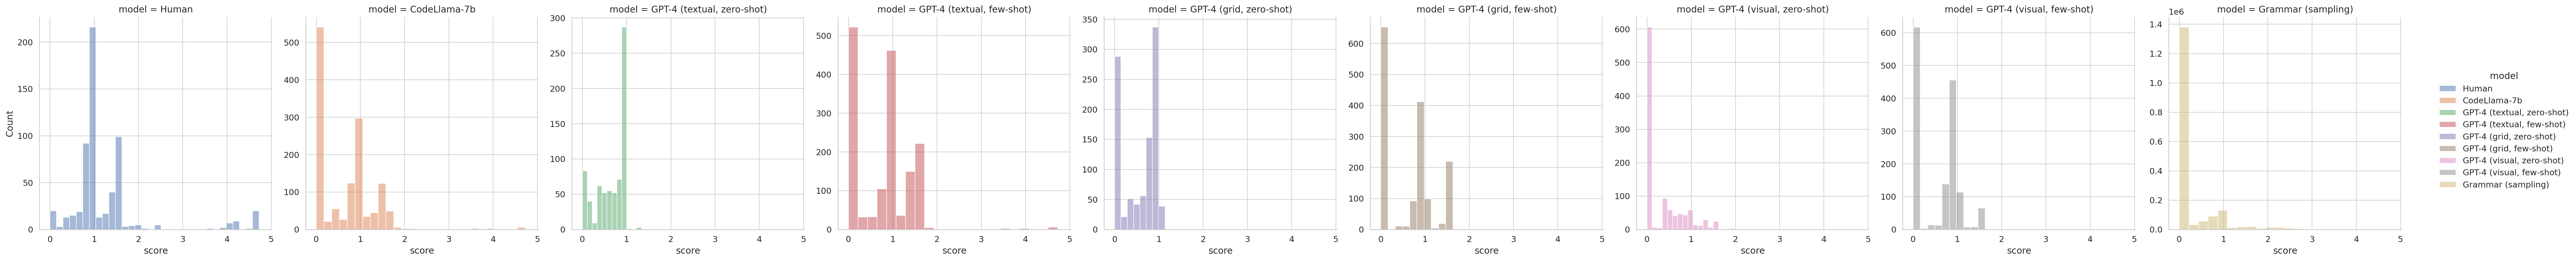

In [33]:
sns.displot(
    data=df_1,
    col="model",
    x="score",
    hue="model",
    common_norm=False,
    common_bins=False,
    facet_kws=dict(sharey=False)
)

### Grouped by trial

Text(0, 0.5, 'EIG')

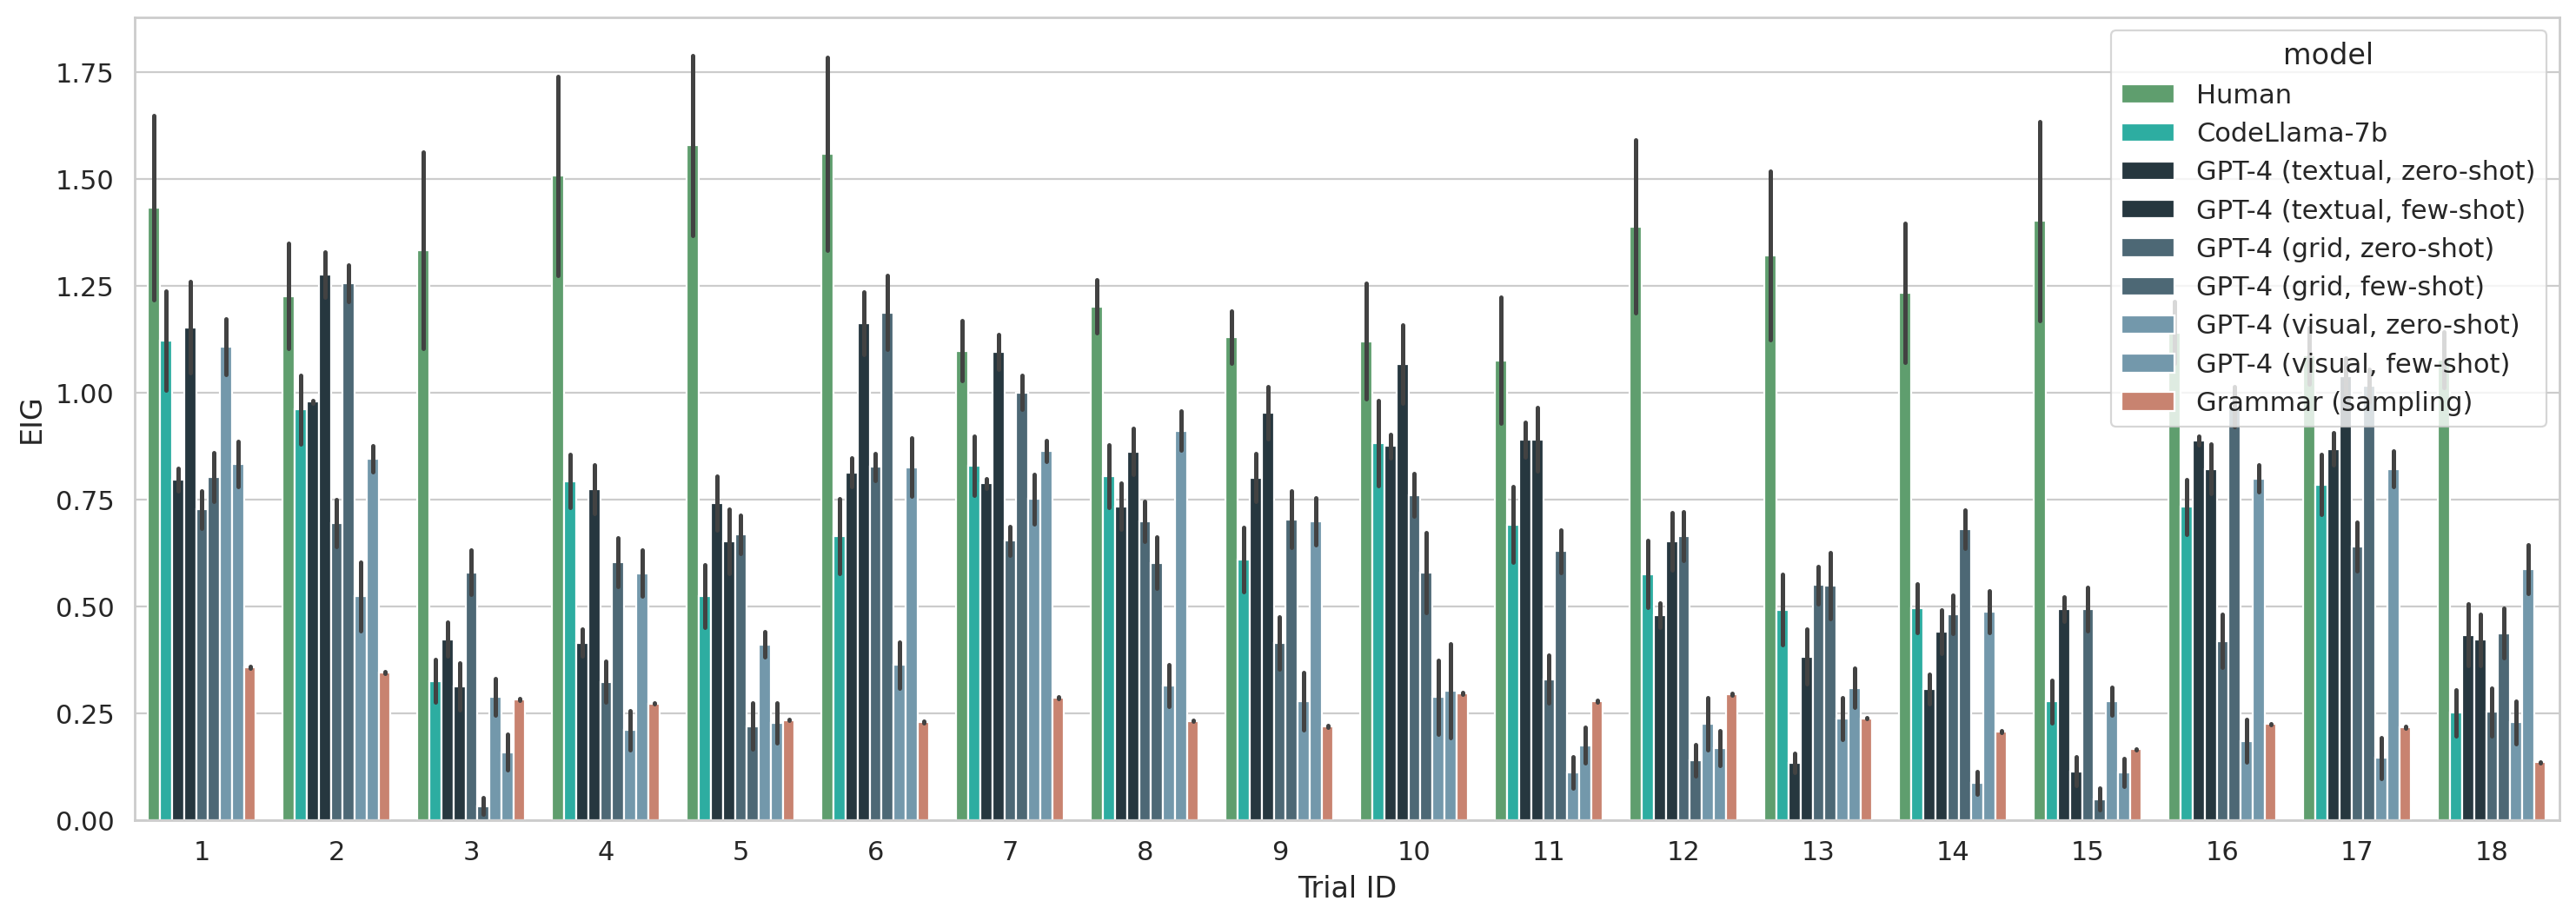

In [34]:
plt.figure(figsize=(18, 6))
sns.barplot(data=df_1, hue="model", x="trial_id", y="score", errorbar="se", palette=PALETTE)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

Text(0, 0.5, 'EIG')

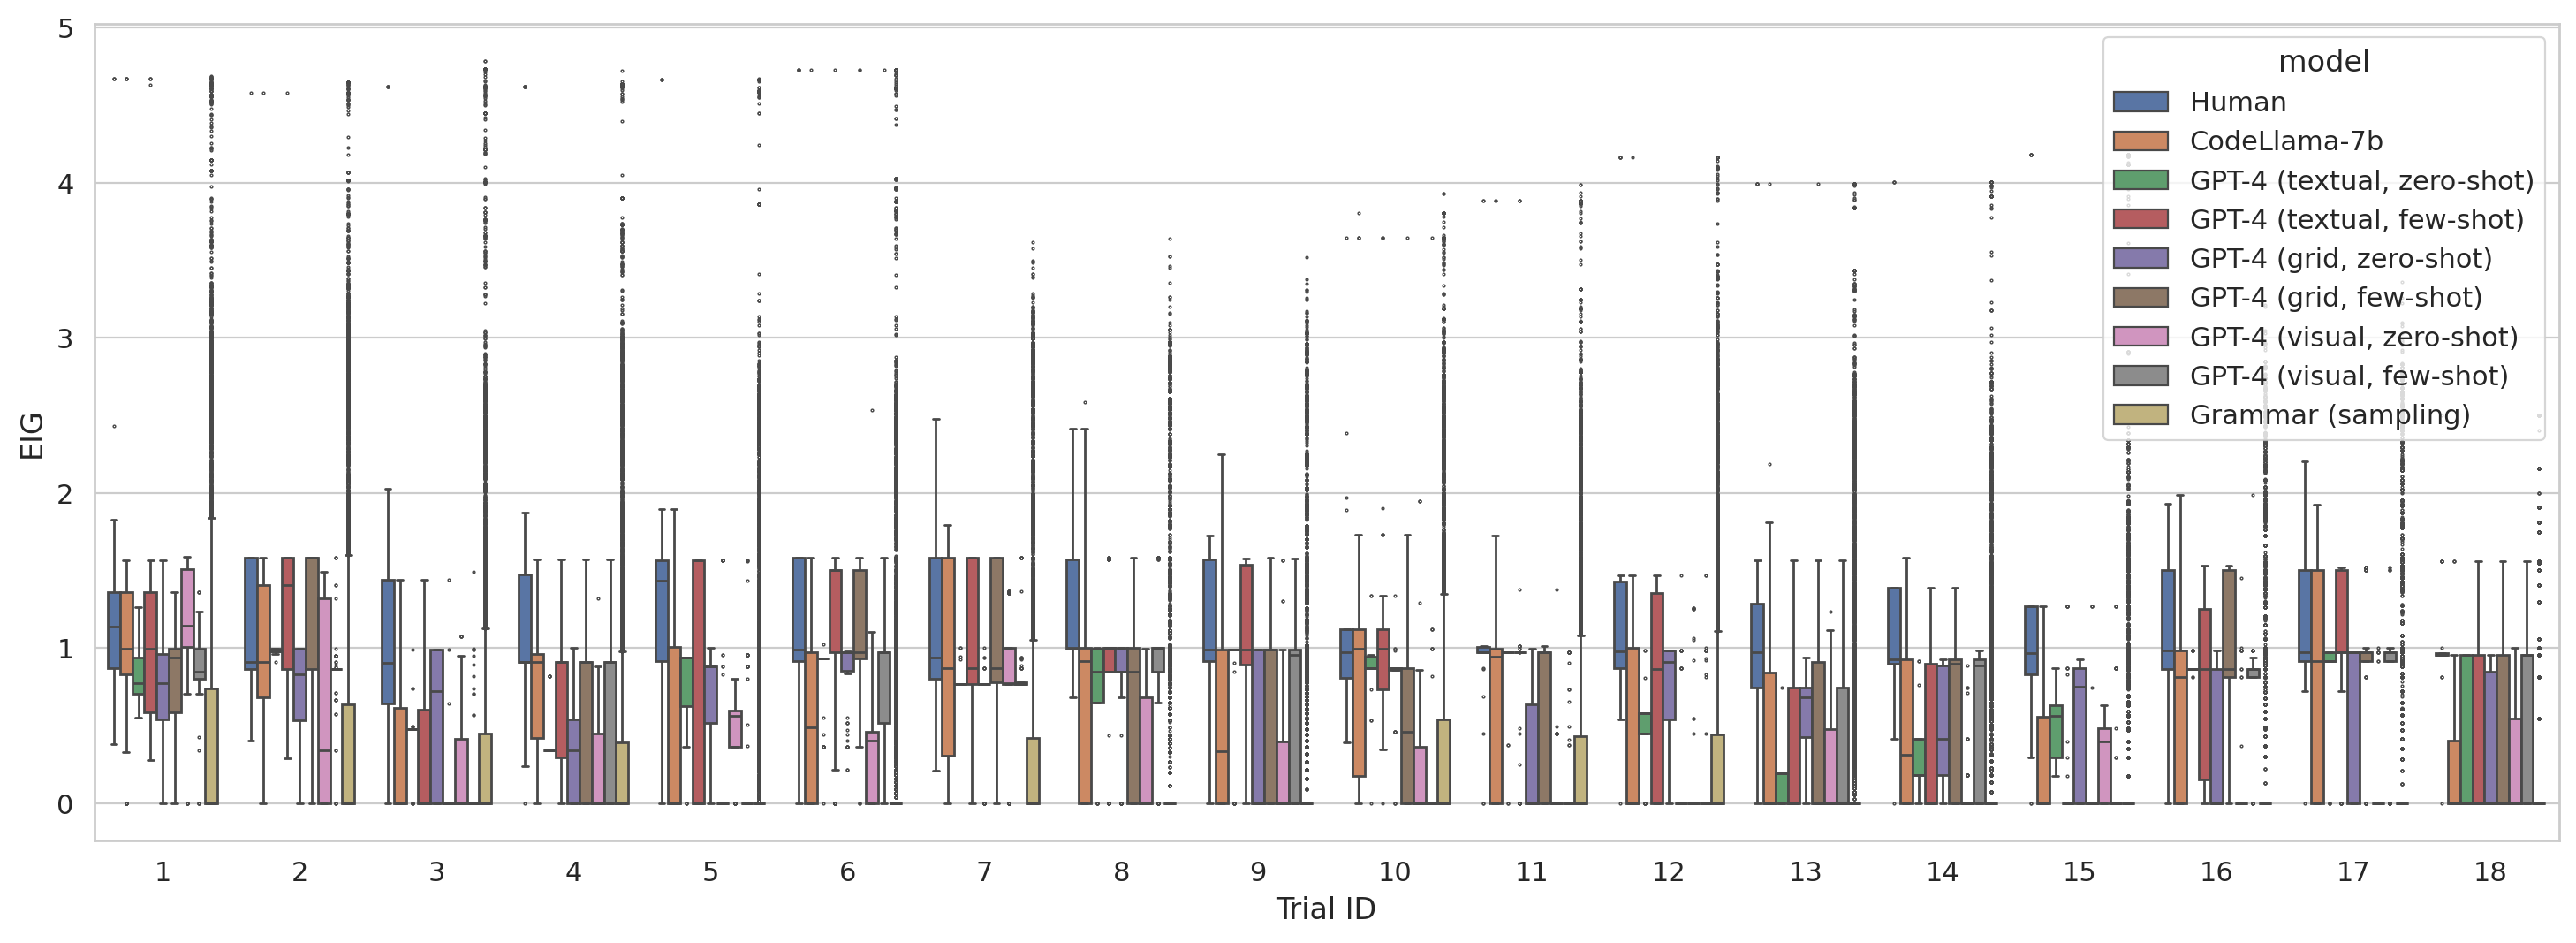

In [35]:
plt.figure(figsize=(18, 6))
# sns.boxplot(data=df, hue="model", x="trial_id", y="score", showfliers=False)
sns.boxplot(
    data=df_1,
    hue="model",
    x="trial_id",
    y="score",
    fliersize=1.0,
    flierprops={"marker": "."},
)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

### EIG Percentile

In [36]:
data = []

human_scores = df_human.score.fillna(value=0).values

for (model, k, trial_id), df_group in df.groupby(["model", "k", "trial_id"]):
    scores = df_group.score.fillna(value=0).values
    for i in range(101):
        percentile_of_model = np.percentile(scores, i)
        percentile_of_human = percentileofscore(human_scores, percentile_of_model).item()
        data.append(
            {
                "model": model,
                "k": k,
                "trial_id": trial_id,
                "percentile": i,
                "score": percentile_of_model,
                "percentile_human": percentile_of_human,
            }
        )

df_eig_sum = pd.DataFrame(data)

In [37]:
df_eig_sum

model  k  trial_id  percentile     score  percentile_human
0      CodeLlama-7b  1         1           0  0.000000          1.735537
1      CodeLlama-7b  1         1           1  0.000000          1.735537
2      CodeLlama-7b  1         1           2  0.000000          1.735537
3      CodeLlama-7b  1         1           3  0.000000          1.735537
4      CodeLlama-7b  1         1           4  0.000000          1.735537
...             ... ..       ...         ...       ...               ...
74533         Human  1        18          96  1.561278         79.173554
74534         Human  1        18          97  1.561278         79.173554
74535         Human  1        18          98  1.842895         91.074380
74536         Human  1        18          99  2.171447         92.396694
74537         Human  1        18         100  2.500000         93.388430

[74538 rows x 6 columns]

Text(0, 0.5, 'EIG')

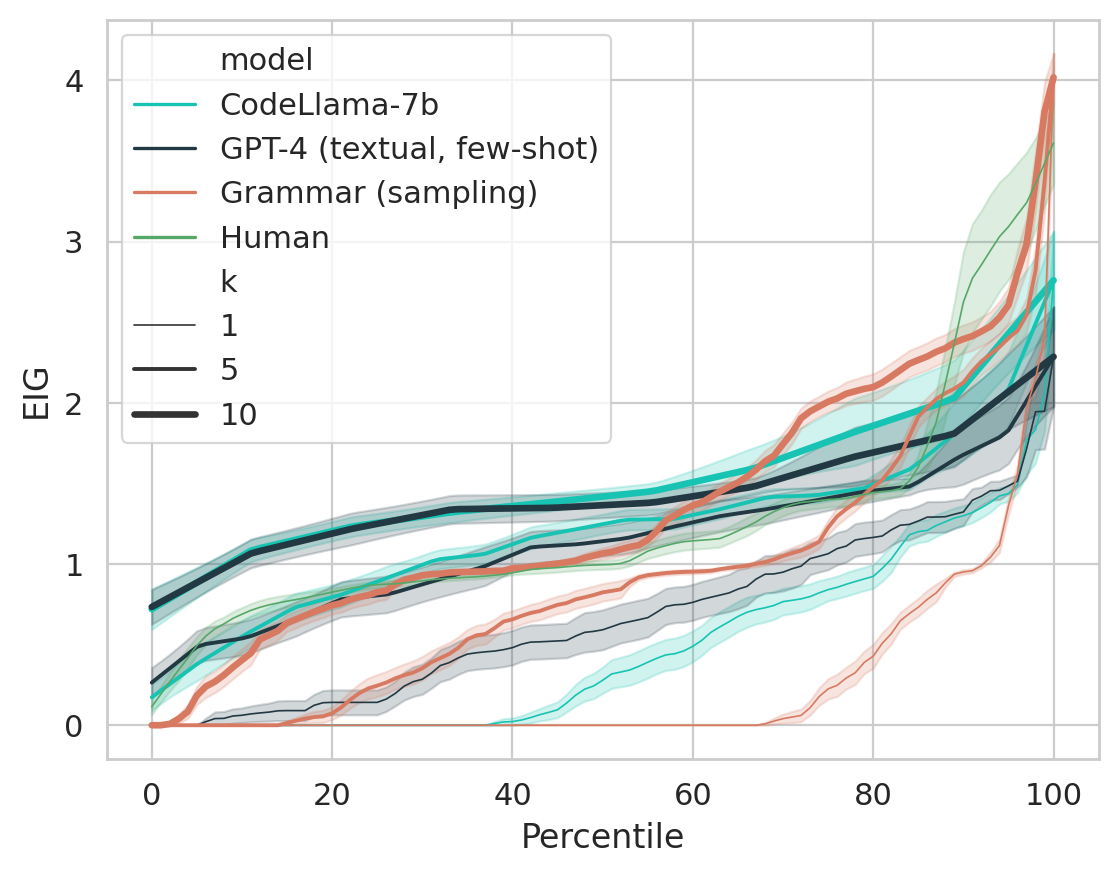

In [38]:
# plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar (sampling)"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

Text(1695.827048611111, 0.5, 'EIG')

<Figure size 1200x800 with 0 Axes>

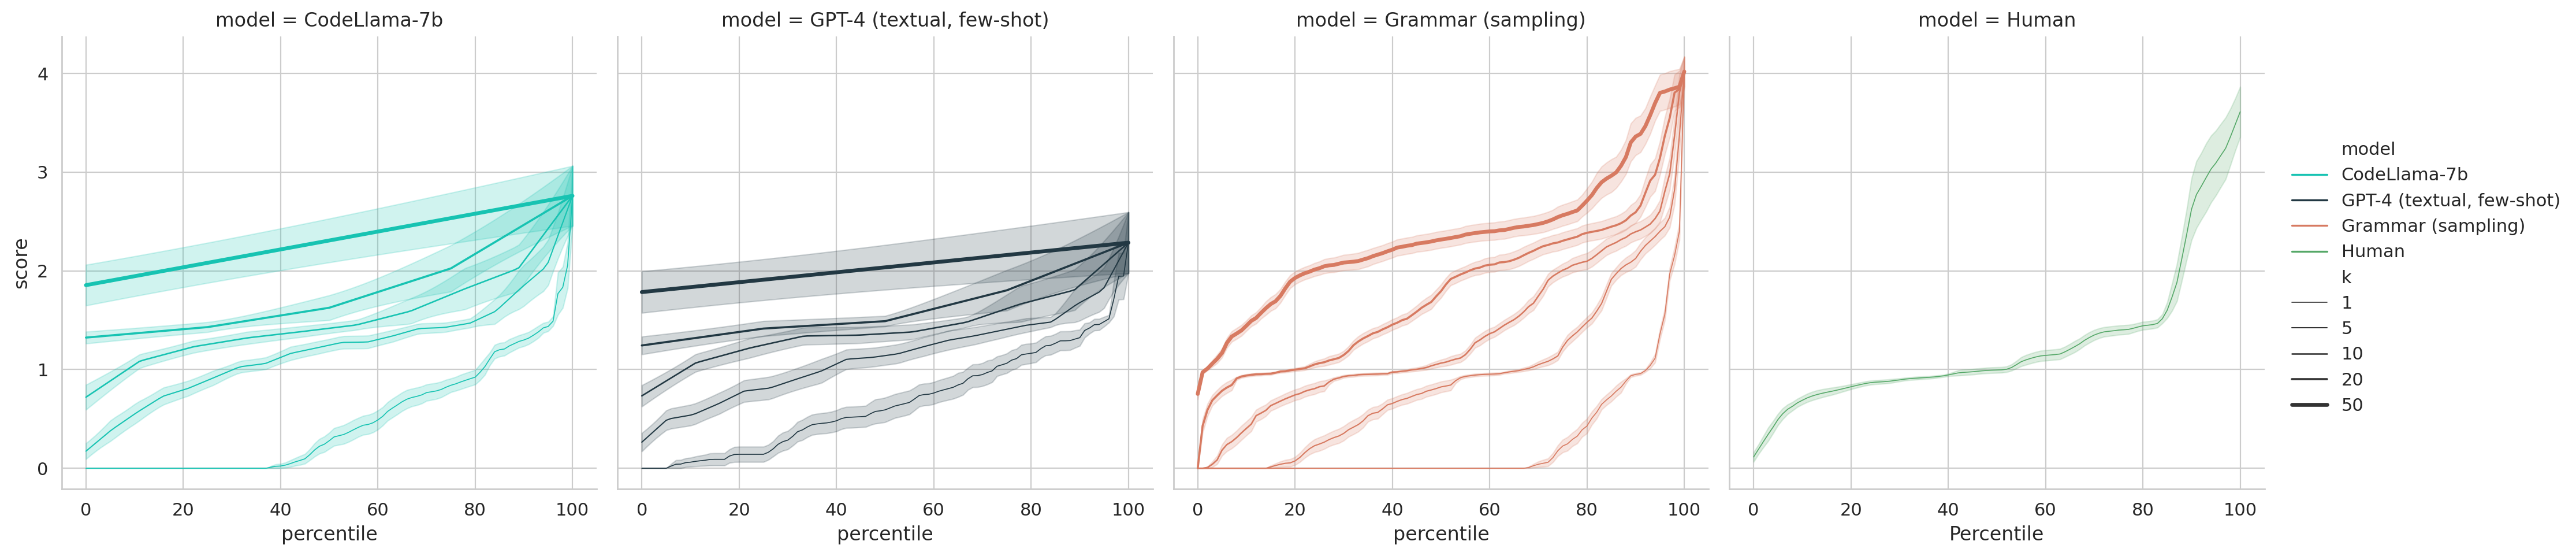

In [39]:
plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar (sampling)"]
sns.relplot(
    kind="line",
    col="model",
    data=df_eig_sum[(df_eig_sum["k"] <= 100) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

Text(0, 0.5, 'Percentile of Human')

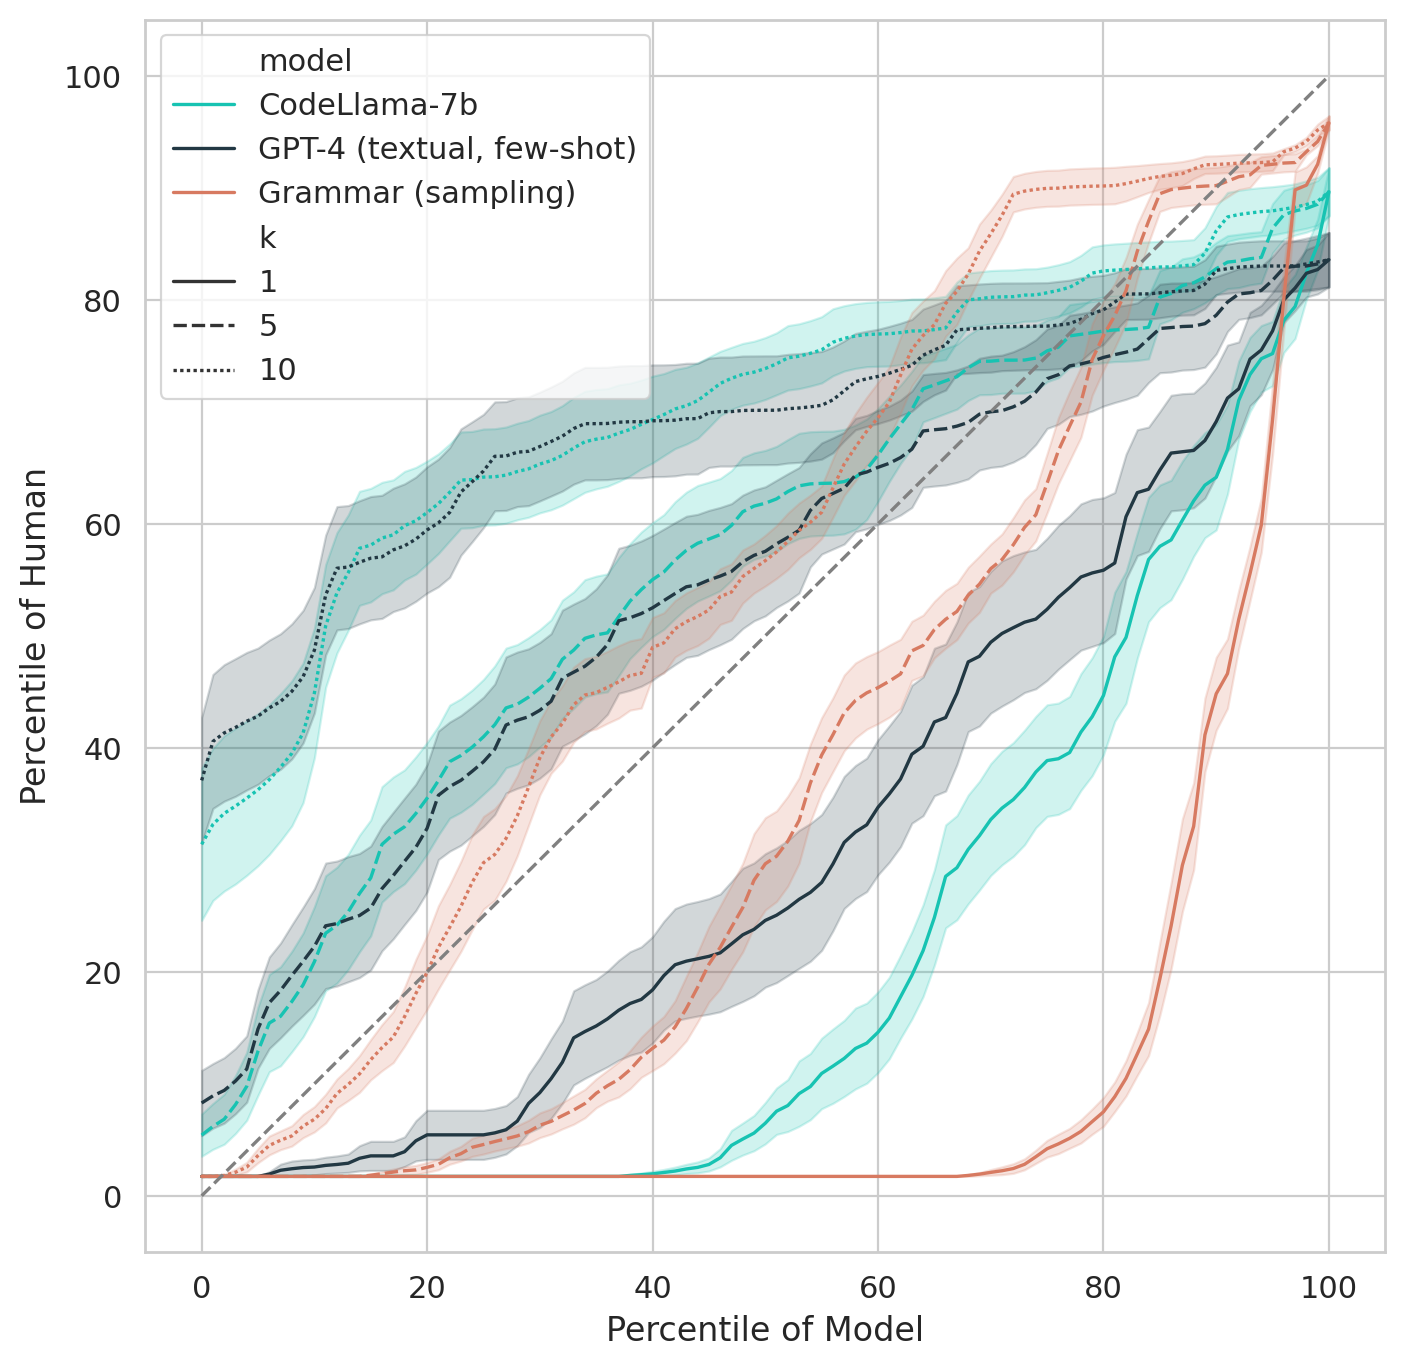

In [40]:
plt.figure(figsize=(8, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar (sampling)"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="percentile_human",
    hue="model",
    style="k",
    errorbar="se",
    palette=PALETTE,
)

# Draw diagonal line
x = np.linspace(0, 100, 100)
plt.plot(x, x, color="gray", linestyle="--")

plt.xlabel("Percentile of Model")
plt.ylabel("Percentile of Human")

<Figure size 800x800 with 0 Axes>

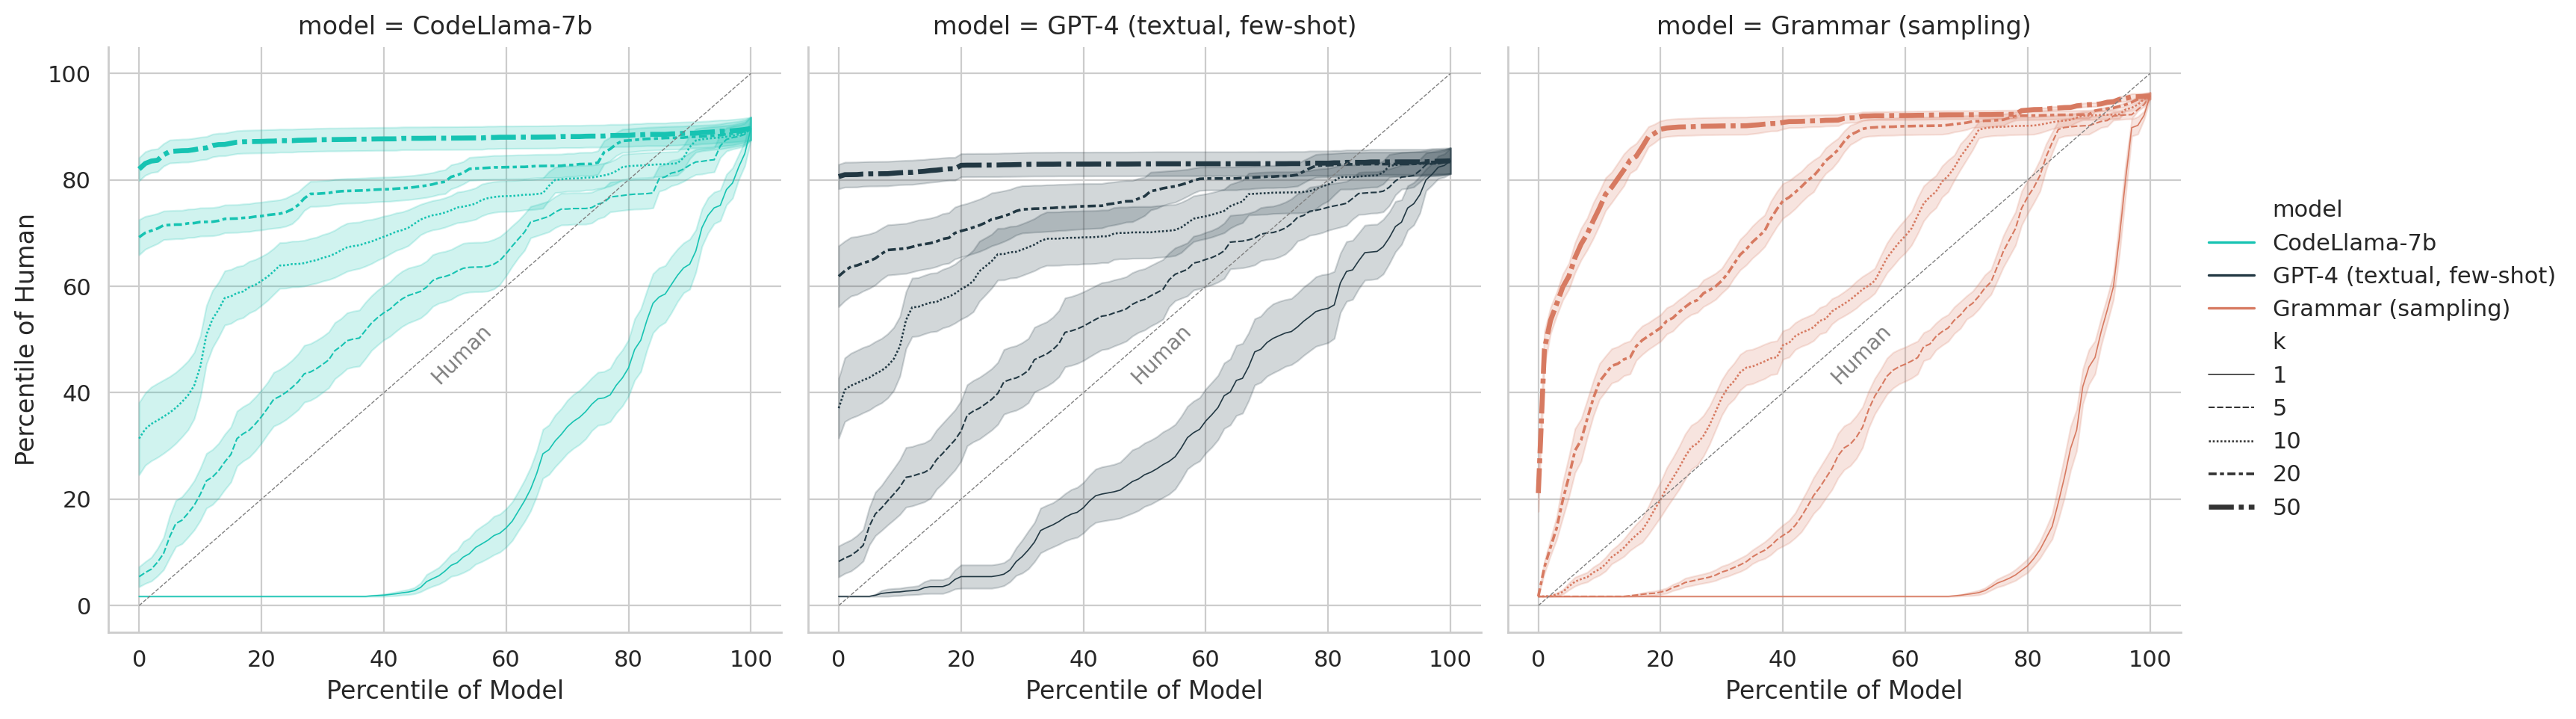

In [41]:
plt.figure(figsize=(8, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar (sampling)"]
sns.relplot(
    kind="line",
    data=df_eig_sum[(df_eig_sum["k"] <= 100) & (df_eig_sum["model"].isin(models))],
    col="model",
    x="percentile",
    y="percentile_human",
    hue="model",
    size="k",
    style="k",
    errorbar="se",
    palette=PALETTE,
)


for ax in plt.gcf().axes:

    # Draw diagonal line on all plots
    x = np.linspace(0, 100, 100)
    ax.plot(x, x, color="gray", linestyle="--", linewidth=0.5)

    # Label the line diagonally
    ax.text(
        0.525,
        0.475,
        "Human",
        color="gray",
        fontsize=10,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        rotation=45,
    )

    ax.set_xlabel("Percentile of Model")
    ax.set_ylabel("Percentile of Human")


## General EIG dists

Text(0, 0.5, 'EIG')

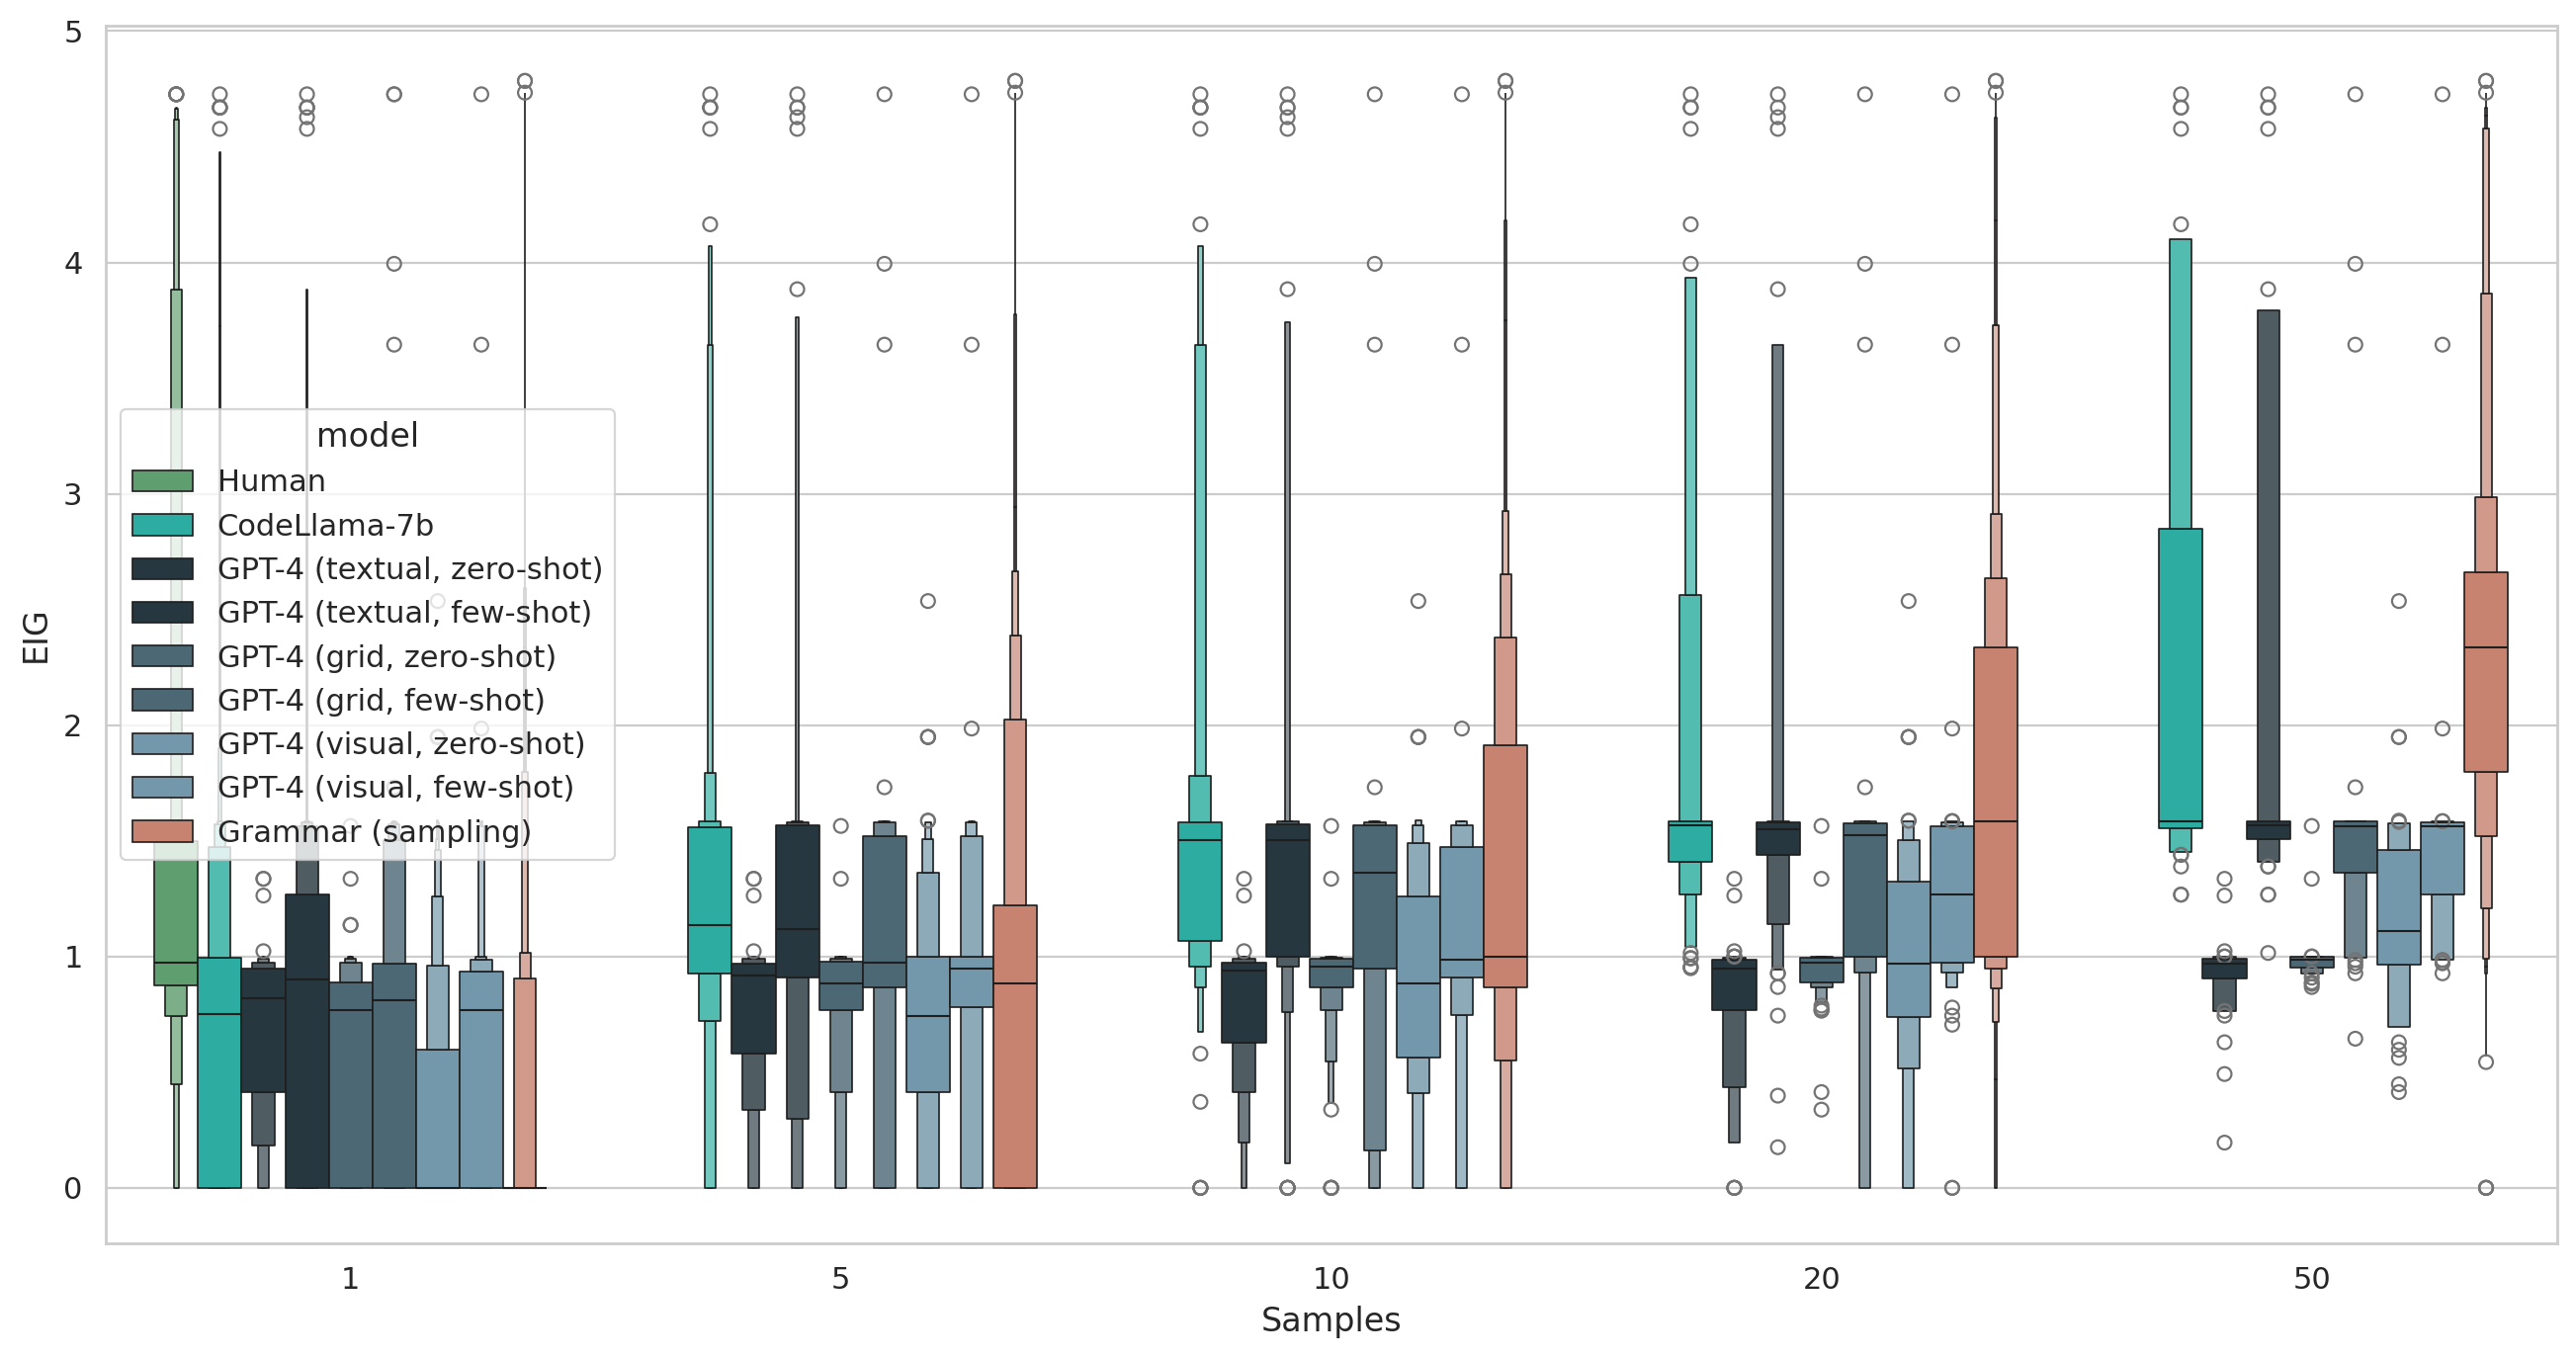

In [42]:
plt.figure(figsize=(16, 8))
# sns.pointplot(data=df, x="k", y="score", hue="model", errorbar="se")
sns.boxenplot(data=df, x="k", y="score", hue="model", palette=PALETTE)
plt.xlabel("Samples")
plt.ylabel("EIG")
# plt.xscale("log")

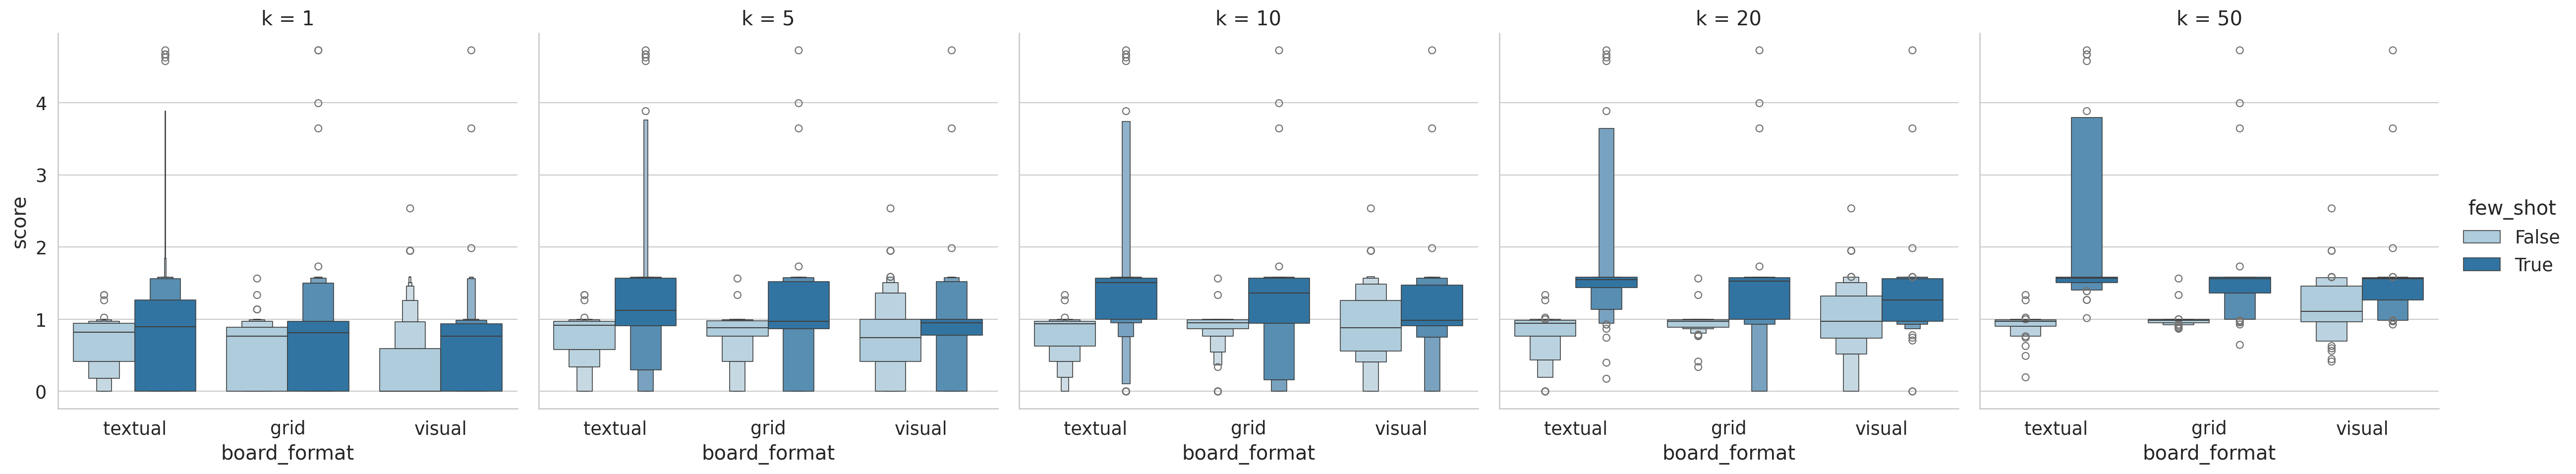

In [43]:
with sns.plotting_context("paper", font_scale=1.5):
    # plt.figure(figsize=(16, 8))

    # neutral 2-color binary palette
    palette = sns.color_palette("Paired", 2)

    sns.catplot(
        kind="boxen",
        data=df[df.model.str.contains("GPT-4")],
        x="board_format",
        y="score",
        hue="few_shot",
        col="k",
        palette=palette,
    )
    # plt.xlabel("Samples")
    plt.ylabel("EIG")

Text(2082.2811044444443, 0.5, 'EIG')

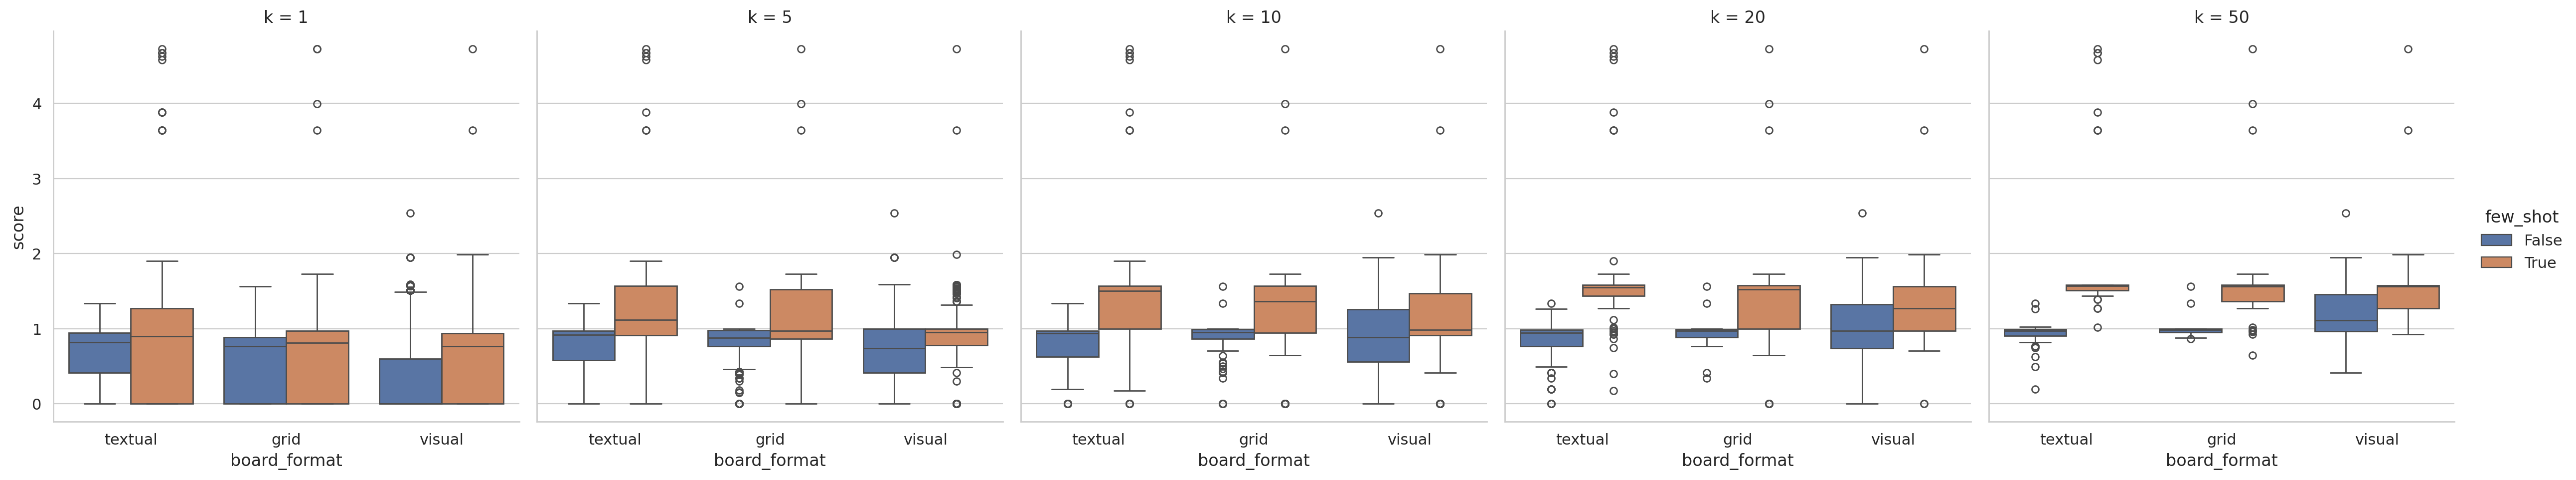

In [44]:
# plt.figure(figsize=(16, 8))
sns.catplot(kind="box", data=df[df.model.str.contains("GPT-4")], x="board_format", y="score", hue="few_shot", col="k")

# sns.lineplot(data=df[df.model.str.contains("GPT-4")], x="k", y="score", hue="board_format", style="few_shot", markers=["o", "o"])
# plt.xlabel("Samples")
plt.ylabel("EIG")
# plt.xscale("log")

Text(0, 0.5, 'Expected Information Gain (EIG)')

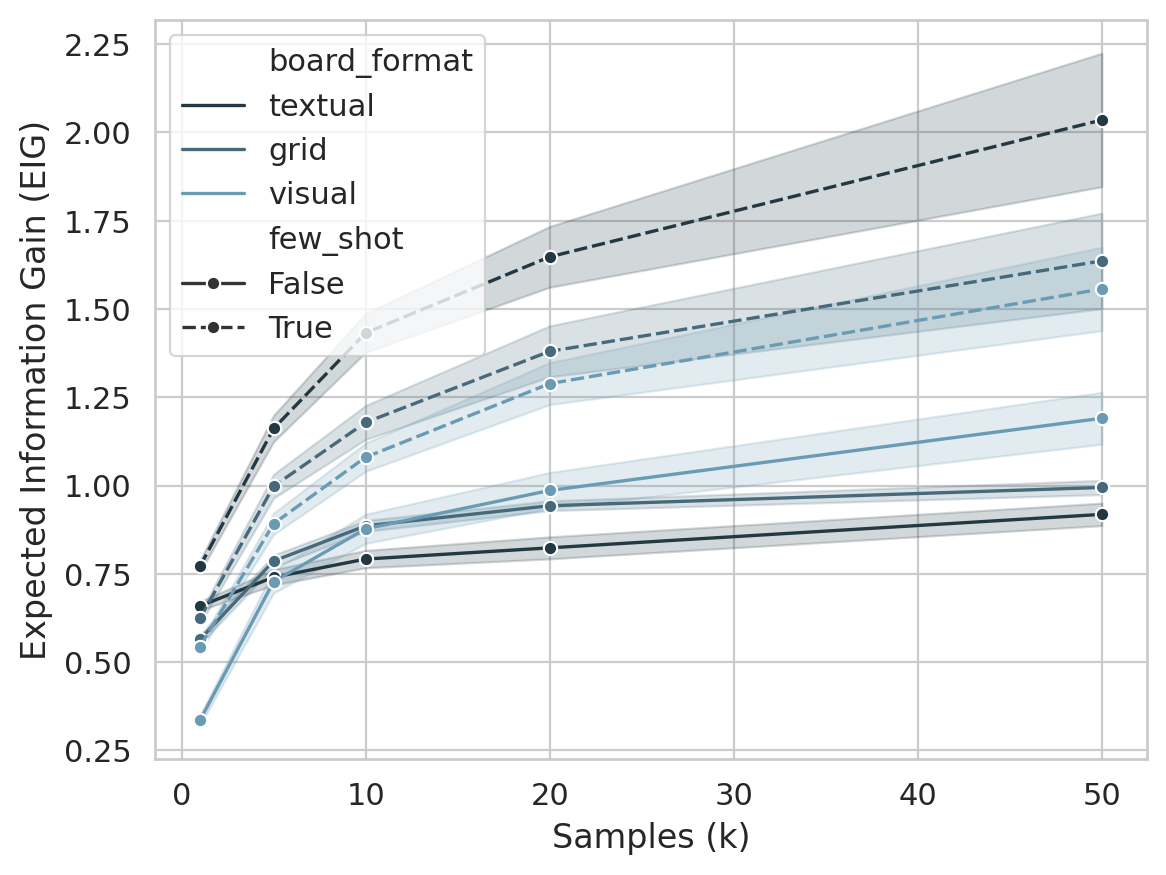

In [45]:
# plt.figure(figsize=(16, 8))

# textual / grid / visual palette
palette = sns.color_palette([COLOR_TEXTUAL, COLOR_GRID, COLOR_VISUAL], n_colors=3)

sns.lineplot(
    data=df[df.model.str.contains("GPT-4")],
    x="k",
    y="score",
    hue="board_format",
    style="few_shot",
    markers=["o", "o"],
    errorbar="se",
    palette=palette,
)
plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")
# plt.xscale("log")

In [46]:
human_mean = df[df.model == "Human"].groupby("trial_id").score.mean().mean()
print(f"Human mean: {human_mean:.3f}")

human_max = df[df.model == "Human"].groupby("trial_id").score.max().mean()
print(f"Human max: {human_max:.3f}")

Human mean: 1.274
Human max: 3.611


Text(0, 0.5, 'Expected Information Gain (EIG)')

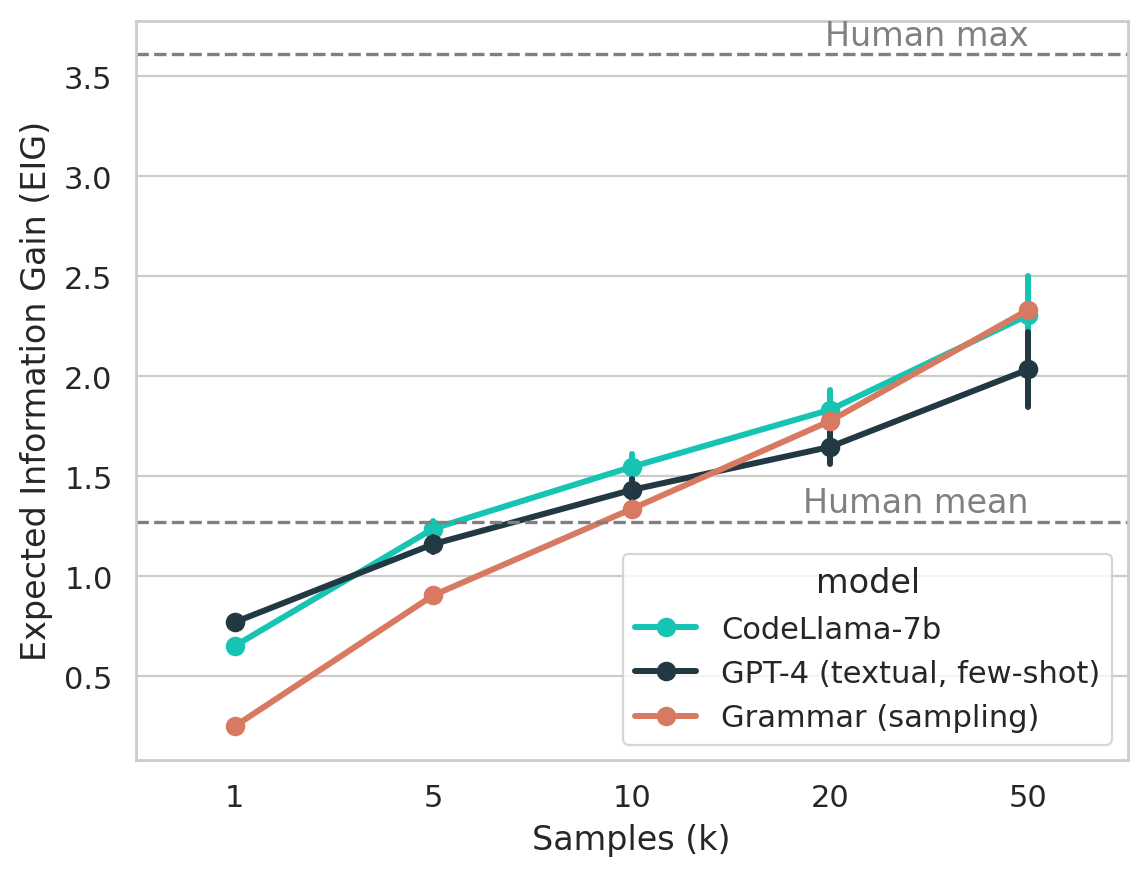

In [47]:
# plt.figure(figsize=(16, 8))

# sns.lineplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
# sns.pointplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
sns.pointplot(data=df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar (sampling)"])], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)


# Add lines for human mean and max
plt.axhline(human_mean, color="gray", linestyle="--")
plt.axhline(human_max, color="gray", linestyle="--")

# Add labels for human mean and max
plt.text(4, human_mean + 0.01, "Human mean", ha="right", va="bottom", color="gray")
plt.text(4, human_max + 0.01, "Human max", ha="right", va="bottom", color="gray")


plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")
# plt.xscale("log")

Text(0, 0.5, 'Expected Information Gain (EIG)')

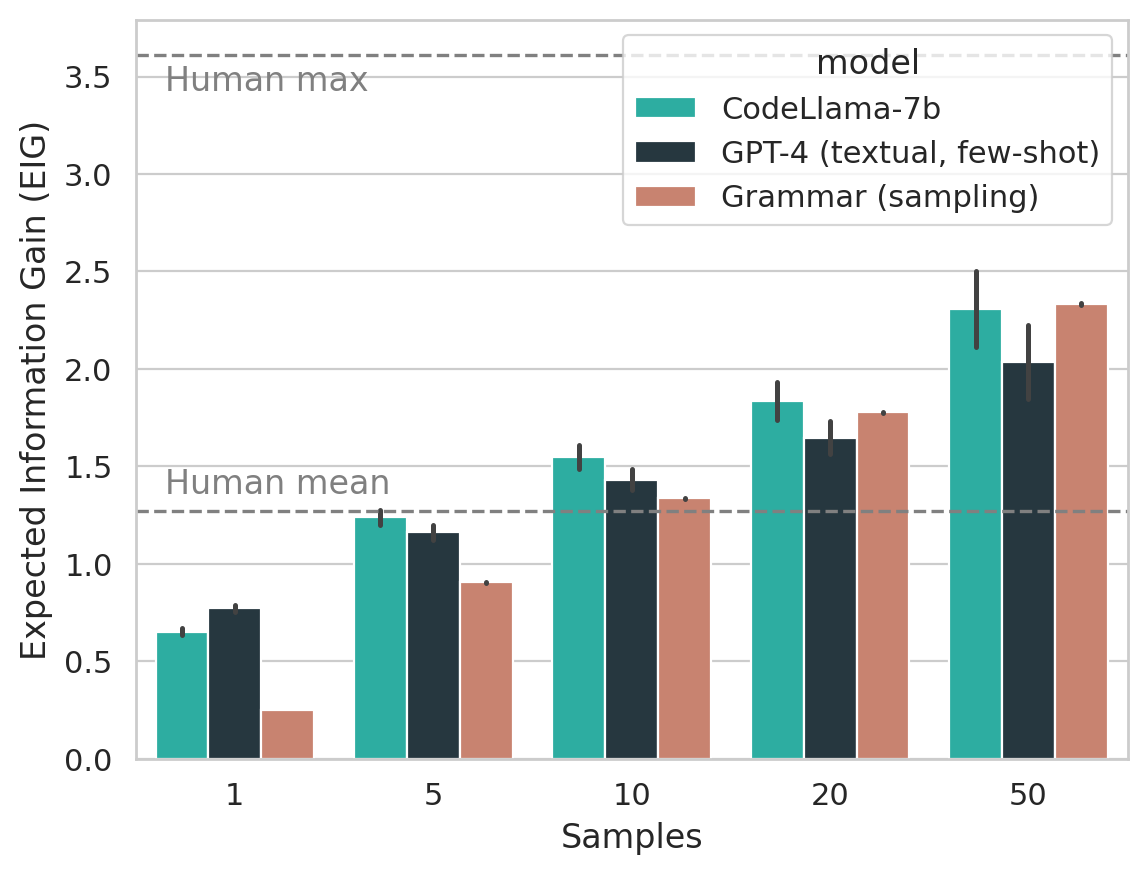

In [48]:
# plt.figure(figsize=(16, 8))

# sns.boxplot(data=df[df.model != "Human"], x="k", y="score", hue="model", palette=PALETTE, showfliers=False)
# sns.barplot(data=df[df.model != "Human"], x="k", y="score", hue="model", palette=PALETTE, errorbar="se")
sns.barplot(data=df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar (sampling)"])], x="k", y="score", hue="model", palette=PALETTE, errorbar="se")


# Add lines for human mean and max
plt.axhline(human_mean, color="gray", linestyle="--")
plt.axhline(human_max, color="gray", linestyle="--")

# Add labels for human mean and max
plt.text(-0.35, human_mean + 0.05, "Human mean", ha="left", va="bottom", color="gray")
plt.text(-0.35, human_max - 0.05, "Human max", ha="left", va="top", color="gray")


plt.xlabel("Samples")
plt.ylabel("Expected Information Gain (EIG)")

In [49]:
df.sort_values("score", ascending=False).head(100).program.tolist()

['( bottomright ( setDifference ( unique ( coloredTiles Purple ) ) ( unique ( intersection ( union ( setDifference ( setDifference ( intersection ( setDifference ( unique ( union ( coloredTiles Purple ) ( coloredTiles ( color 3D ) ) ) ) ( coloredTiles ( color 6E ) ) ) ( coloredTiles ( color 2B ) ) ) ( set AllTiles ) ) ( set AllTiles ) ) ( set AllTiles ) ) ( coloredTiles ( color 3D ) ) ) ) ) )',
 '( bottomright ( union ( unique ( setDifference ( setDifference ( unique ( unique ( unique ( coloredTiles Water ) ) ) ) ( set AllTiles ) ) ( unique ( intersection ( set AllTiles ) ( coloredTiles Water ) ) ) ) ) ( unique ( unique ( setDifference ( intersection ( unique ( coloredTiles Red ) ) ( set AllTiles ) ) ( coloredTiles ( color 3D ) ) ) ) ) ) )',
 '( bottomright ( union ( unique ( setDifference ( setDifference ( unique ( unique ( unique ( coloredTiles Water ) ) ) ) ( set AllTiles ) ) ( unique ( intersection ( set AllTiles ) ( coloredTiles Water ) ) ) ) ) ( unique ( unique ( setDifference ( 

# Grammar

<Axes: xlabel='depth', ylabel='Probability'>

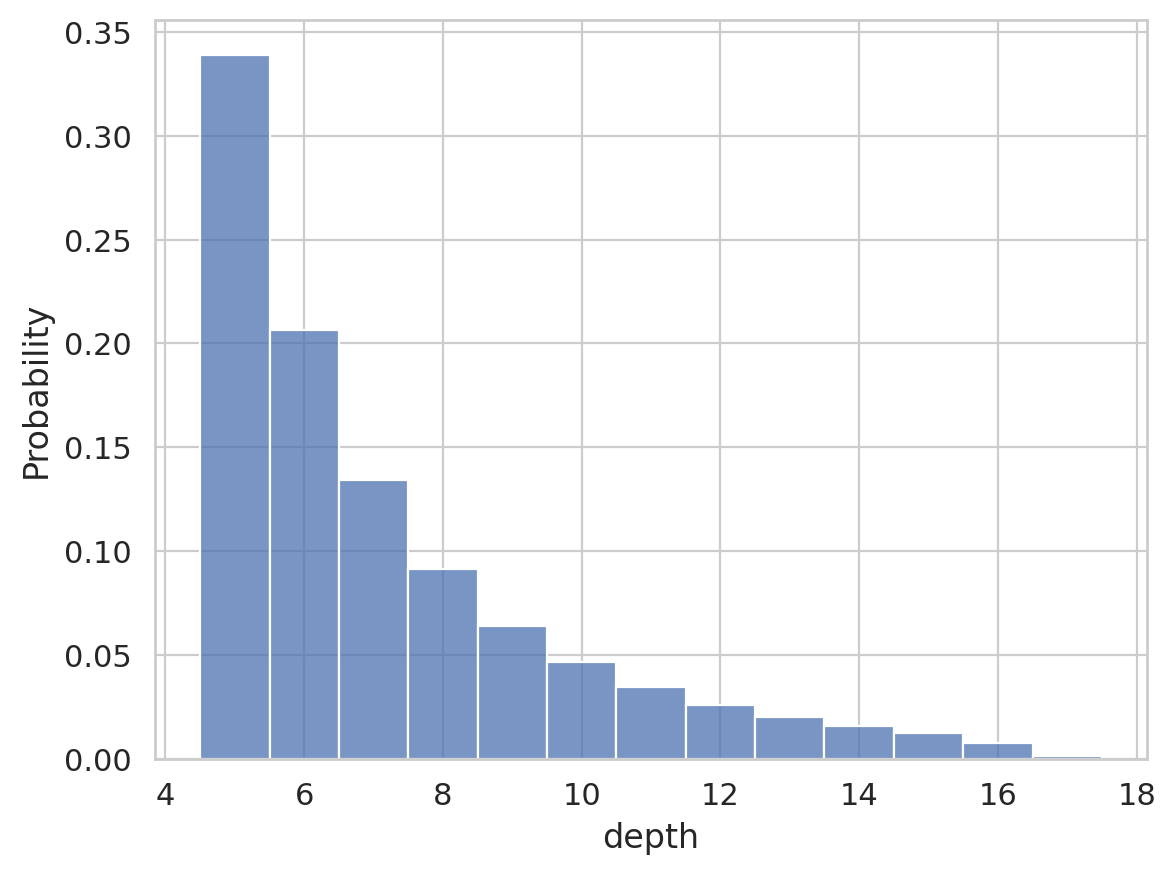

In [54]:
sns.histplot(df[df.model == "Grammar (sampling)"].depth, stat="probability", discrete=True)

In [51]:
df[df.model == "Grammar (sampling)"].sort_values("depth", ascending=True).program.tolist()[:100]

['( + ( == 4 5 ) ( isSubset ( coloredTiles ( color 1A ) ) ( set AllTiles ) ) )',
 '( < 0 ( + ( + 1 ( colL 6A ) ) ( + 1 ( - 6 6 ) ) ) )',
 '( and ( == H ( orient Red ) ) ( not ( > 1 ( rowL 2E ) ) ) )',
 '( == ( touch Blue Blue ) ( == ( not ( > 2 4 ) ) ( == ( orient Red ) V ) ) )',
 '( setSize ( intersection ( intersection ( coloredTiles Water ) ( set AllTiles ) ) ( coloredTiles ( color 6B ) ) ) )',
 '( + ( setSize ( unique ( coloredTiles Purple ) ) ) 7 )',
 '( + ( rowL 1F ) ( setSize ( setDifference ( set AllTiles ) ( coloredTiles Water ) ) ) )',
 '( - 6 ( - ( + ( size Purple ) 1 ) ( colL 5C ) ) )',
 '( isSubset ( coloredTiles Water ) ( union ( coloredTiles ( color 1E ) ) ( set AllTiles ) ) )',
 '( > 4 ( setSize ( coloredTiles ( color 2D ) ) ) )',
 '( - ( setSize ( coloredTiles ( color 2C ) ) ) 9 )',
 '( + FALSE ( == ( > 8 0 ) ( == Water ( color 1D ) ) ) )',
 '( == ( < 0 2 ) ( not ( not ( == 5 0 ) ) ) )',
 '( and ( touch Purple Purple ) ( == TRUE ( not ( == 2 4 ) ) ) )',
 '( == ( < ( se

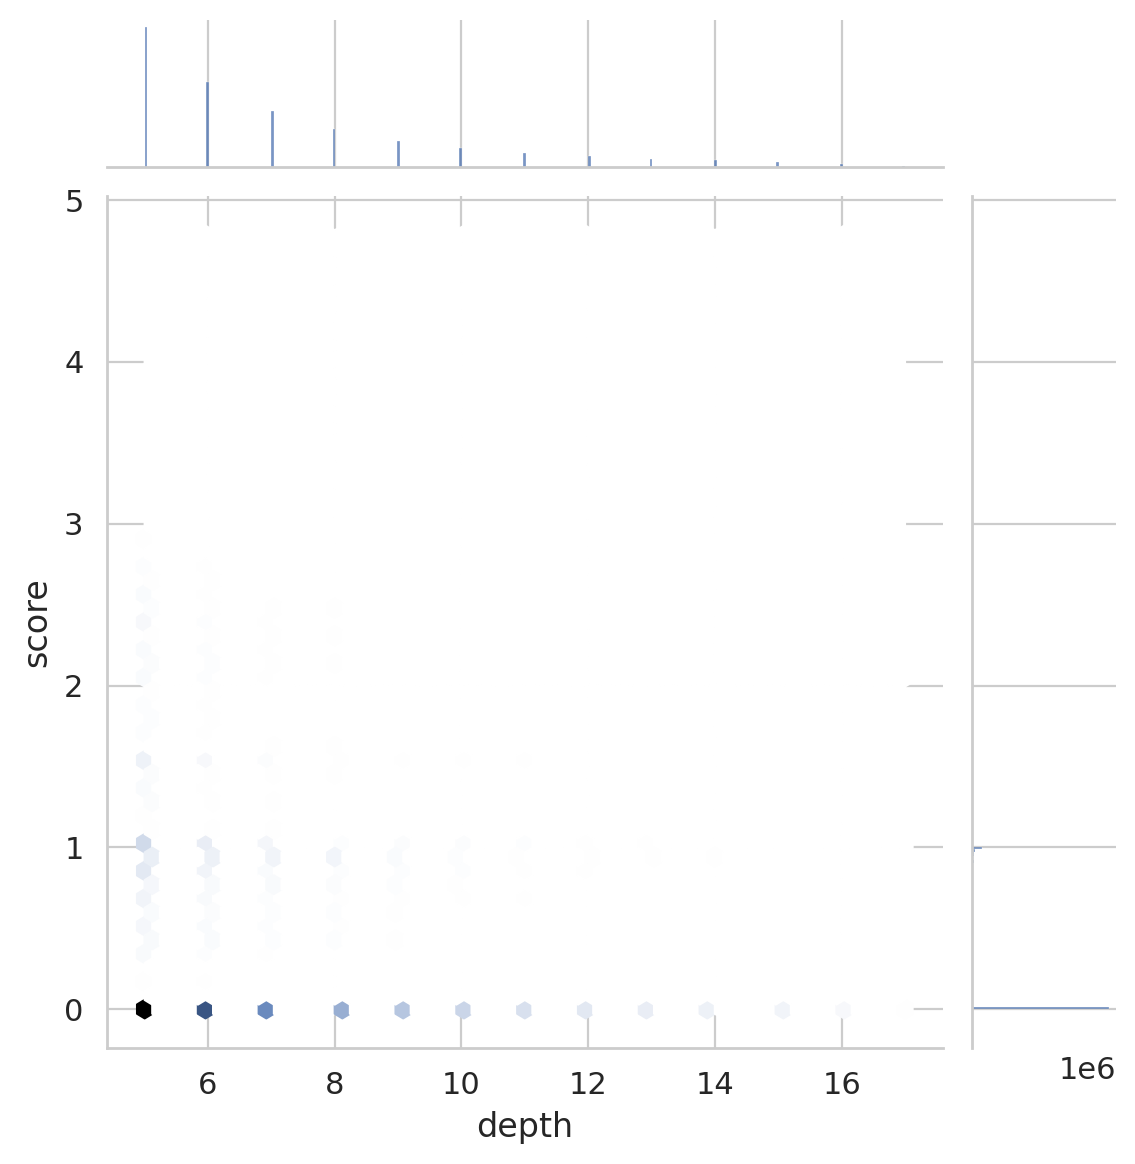

In [52]:
sns.jointplot(data=df[df.model == "Grammar (sampling)"], x="depth", y="score", kind="hex")